<a href="https://www.kaggle.com/code/nghianguyenduy1601/final-advanced-da?scriptVersionId=249588172" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from sklearn.preprocessing import OneHotEncoder
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rossmannsales/X_train_1097.csv
/kaggle/input/rossmannsales/y_train_1097.csv
/kaggle/input/rossmannsales/y_train.csv
/kaggle/input/rossmannsales/X_train.csv
/kaggle/input/rossmannsales/Datasets/sample_submission.csv
/kaggle/input/rossmannsales/Datasets/store.csv
/kaggle/input/rossmannsales/Datasets/train.csv
/kaggle/input/rossmannsales/Datasets/test.csv


In [2]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from datetime import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# prophet by Facebook
# from fbprophet import Prophet
from prophet import Prophet

In [3]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

# Exploratory Data Analysis

In [4]:
# importing train data to learn
train = pd.read_csv("/kaggle/input/rossmannsales/Datasets/train.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')

# additional store data
store = pd.read_csv("/kaggle/input/rossmannsales/Datasets/store.csv", 
                    low_memory = False)
# time series as indexes

train = train.loc[lambda df: df.Store == 1]


train.index

DatetimeIndex(['2015-07-31', '2015-07-30', '2015-07-29', '2015-07-28',
               '2015-07-27', '2015-07-26', '2015-07-25', '2015-07-24',
               '2015-07-23', '2015-07-22',
               ...
               '2013-01-10', '2013-01-09', '2013-01-08', '2013-01-07',
               '2013-01-06', '2013-01-05', '2013-01-04', '2013-01-03',
               '2013-01-02', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=942, freq=None)

In [5]:
# first glance at the train set: head and tail
print("In total: ", train.shape)
train.head(5)

In total:  (942, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-30,1,4,5020,546,1,1,0,1
2015-07-29,1,3,4782,523,1,1,0,1
2015-07-28,1,2,5011,560,1,1,0,1
2015-07-27,1,1,6102,612,1,1,0,1


## Data featuring

In [6]:
# data extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.isocalendar().week

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    781.000000
mean       8.393038
std        0.689619
min        6.513228
25%        7.903475
50%        8.362376
75%        8.891304
max       10.536503
Name: SalePerCustomer, dtype: float64

On average customers spend about ~8.50$ per day. Though there are days with Sales equal to zero

## ECDF: empirical cumulative distribution function

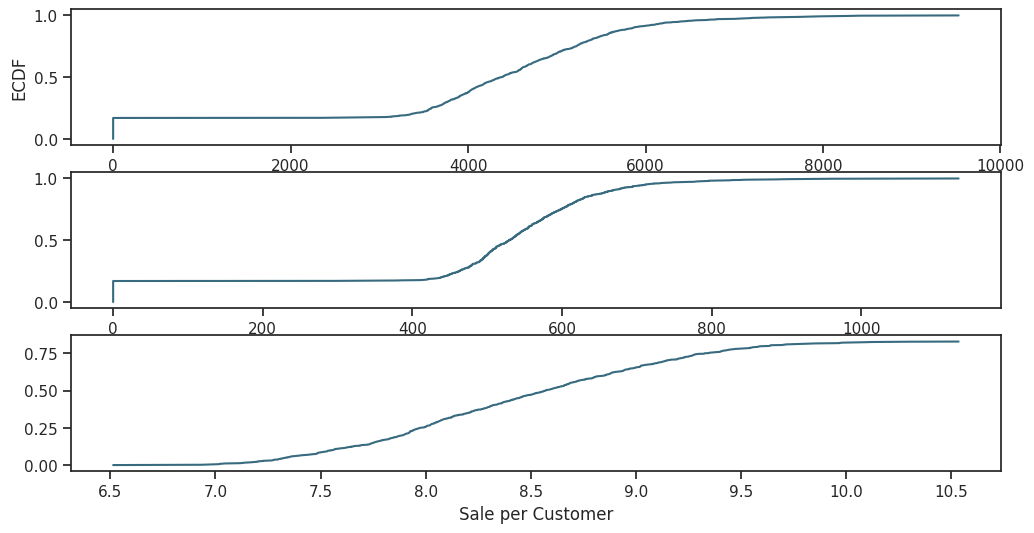

In [7]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

About 20% of data has zero amount of sales / customers that we need to deal with and almost 80% of time daily amount of sales was less than 800. So what about zero sales, is it only due to the fact that the store is closed?

## Closed date

In [8]:
# closed stores
train[(train.Open == 0) & (train.Sales == 0)].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-26,1,7,0,0,0,0,0,0,2015,7,26,30,NaN
2015-07-19,1,7,0,0,0,0,0,0,2015,7,19,29,NaN
2015-07-12,1,7,0,0,0,0,0,0,2015,7,12,28,NaN
2015-07-05,1,7,0,0,0,0,0,0,2015,7,5,27,NaN
2015-06-28,1,7,0,0,0,0,0,0,2015,6,28,26,NaN


## Sales>0 selection

In [9]:
print("Closed stores and days which didn't have any sales won't be counted into the forecasts.")
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("In total: ", train.shape)

Closed stores and days which didn't have any sales won't be counted into the forecasts.
In total:  (781, 13)


## Insight Revealing

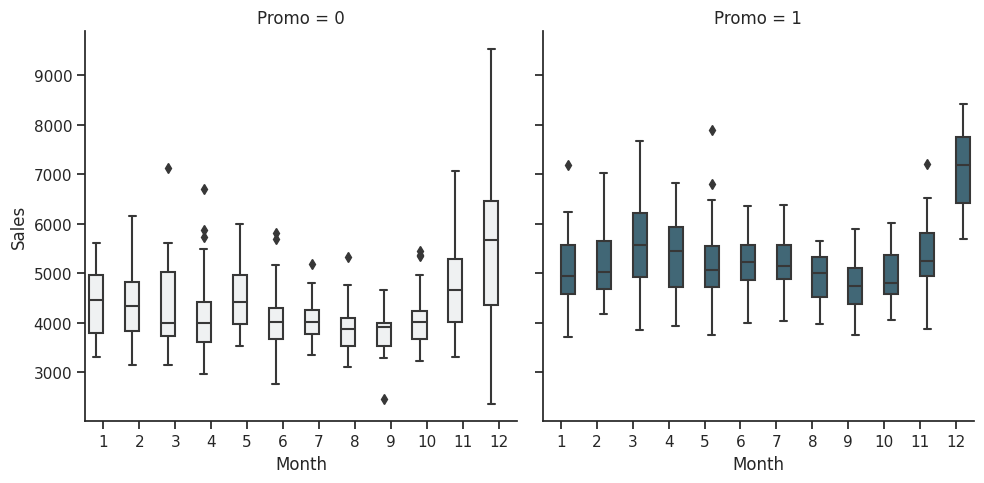

In [54]:
# sales trends
sns.catplot(data = train, x = 'Month', y = "Sales", 
               # col = 'StoreType', # per store type in cols
               # palette = 'plasma',
               hue = 'Promo',
               col = 'Promo', # per promo in the store in rows
                kind="box",
               color = c) 

**Promo = 0: No Promotion**
* Flat/declining trend in middle months (June to October)
* Highest sales in December — likely driven by seasonality (e.g., holidays), not just promotion
* More variance in earlier months
* Outliers present (especially in Months 1, 2, 12)

**Promo = 1: With Promotion**
* Sales are consistently higher across all months compared to Promo = 0
* Narrower interquartile ranges (IQR) — less variation in some months, e.g., Month 10–11
* Highest median sales again in December, but with promo the sales are even better
* Some months (e.g., January, March) have significantly higher medians vs. no-promo months

**Summary**
* Promotions are effective: Median sales during promotions are consistently higher across months.
* Seasonality interacts with promotions:
    * December shows synergistic effect (seasonal + promo = max sales).
* Promotions may stabilize sales:
    * Reduced variability in months like August–October compared to no-promo group.



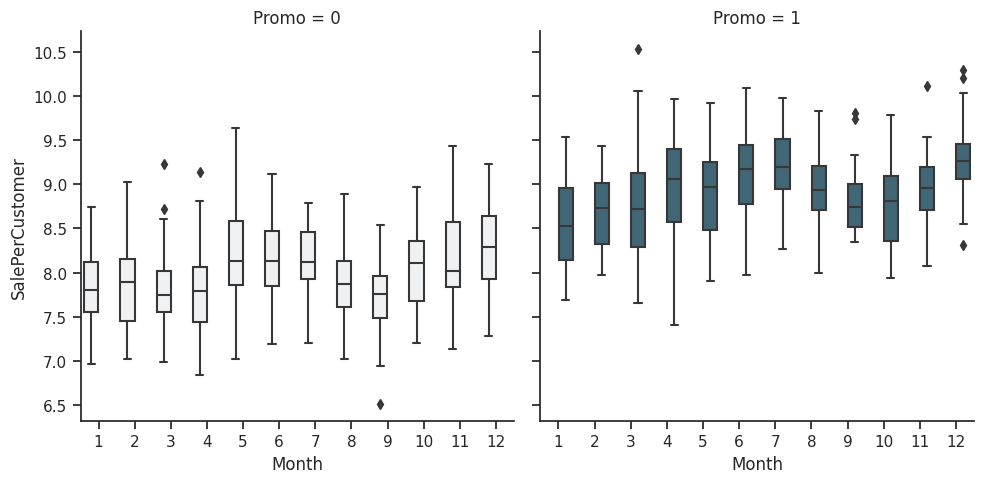

In [55]:
# sales trends
sns.catplot(data = train, x = 'Month', y = "SalePerCustomer", 
               # col = 'StoreType', # per store type in cols
               # palette = 'plasma',
               hue = 'Promo',
               col = 'Promo', # per promo in the store in rows
                kind="box",
               color = c) 

**Promo = 0 (No Promotion)**
* Median stays flat across months — around 8.0
* December shows slight uplift, possibly seasonal (holiday-driven)
* Some low outliers (e.g., Month 6)
* No clear monthly pattern; appears stable but not exceptional

**Promo = 1 (With Promotion)**
* Higher and more consistent median: between 8.8 to 9.2
* Seasonal peak in December is stronger, suggesting promotion enhances holiday effect
* Some months (e.g., 4–7) show pronounced uplift in median
* Tighter IQR (less variance) in late months → promotions may stabilize per-customer behavior

**Intepretation**
* Promotions increase average spend per customer across almost all months.
* Combined promotion + seasonality (e.g., December) significantly improves performance.
* Promo customers are more consistent, with higher medians and narrower spreads in many cases.
* Could suggest effective targeting or bundling during promos.

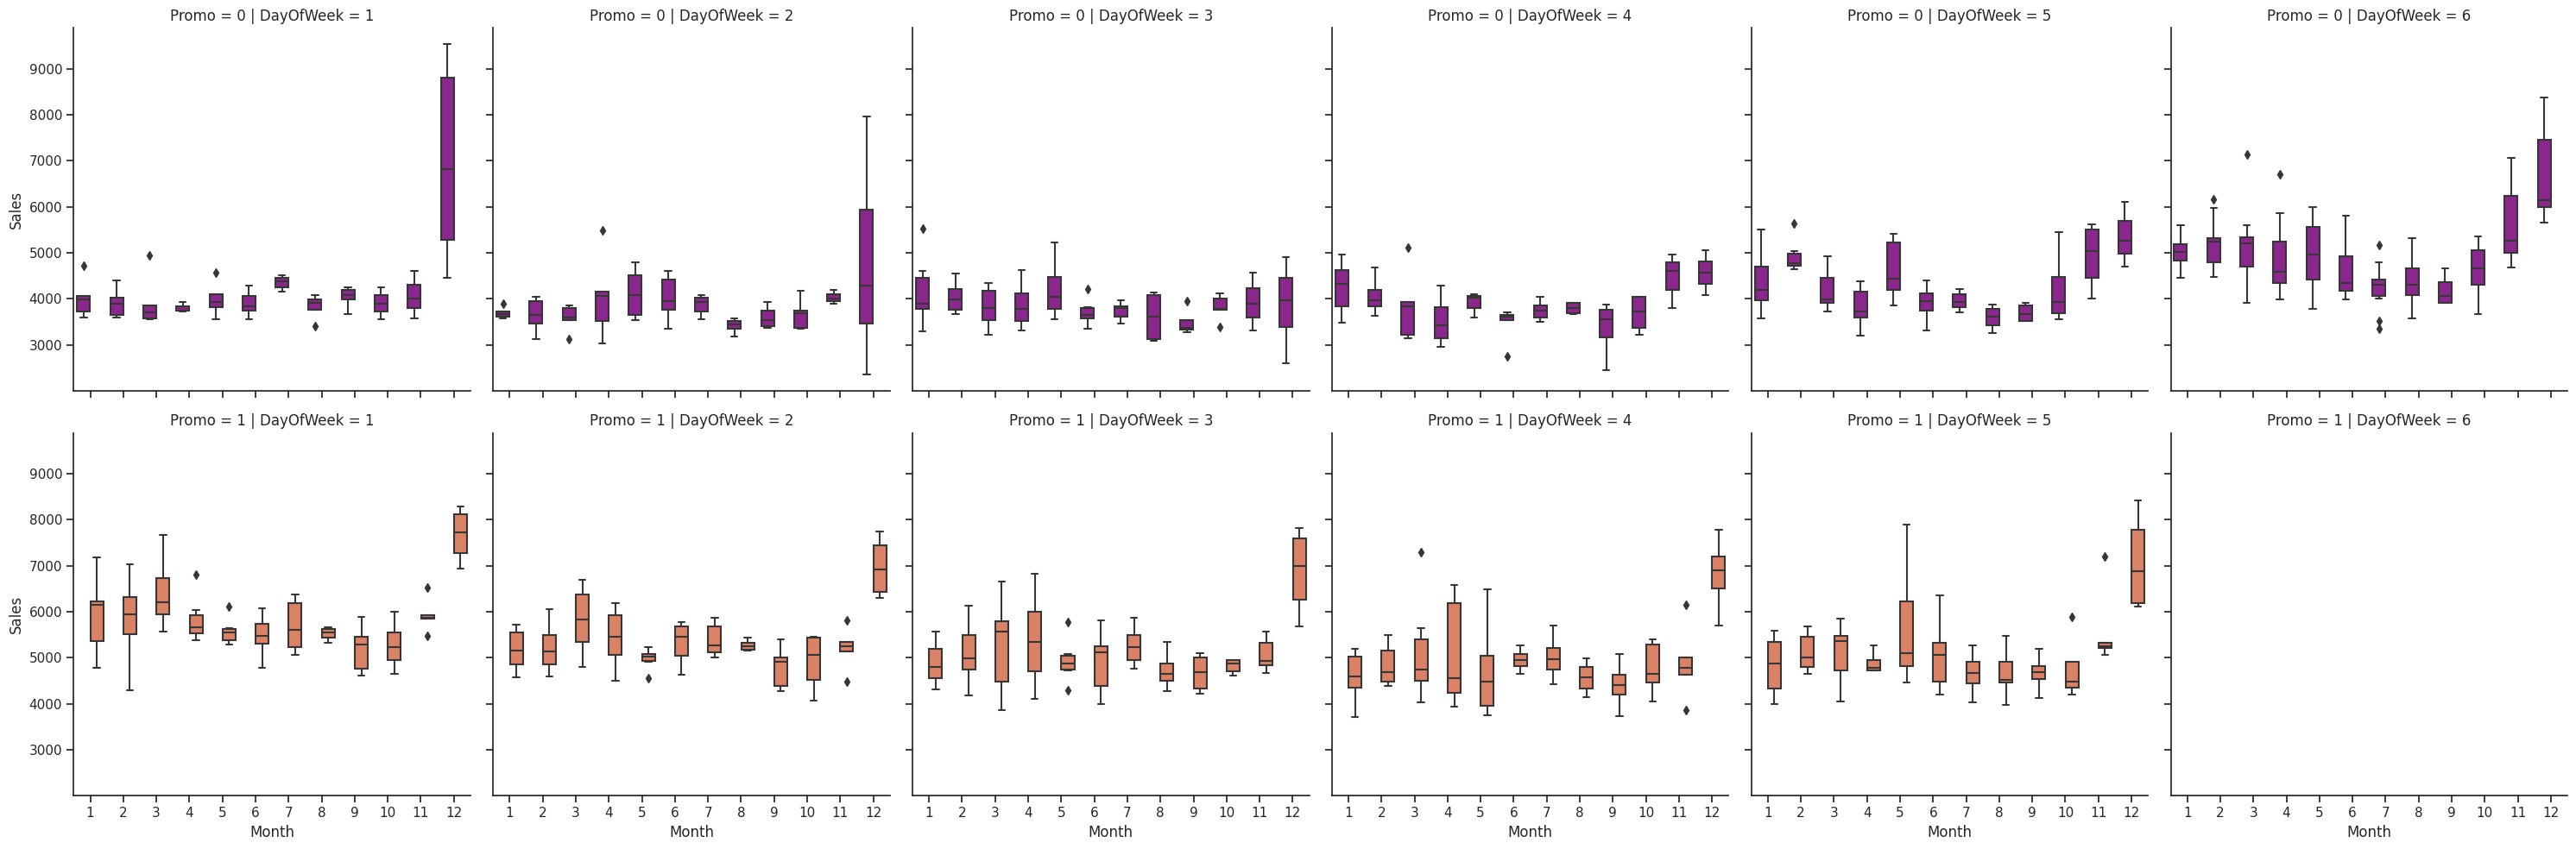

In [12]:
# sales trends
sns.catplot(data = train, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               palette = 'plasma',
               hue = 'Promo',
               row = 'Promo', # per promo in the store in rows
                kind="box",
               color = c)

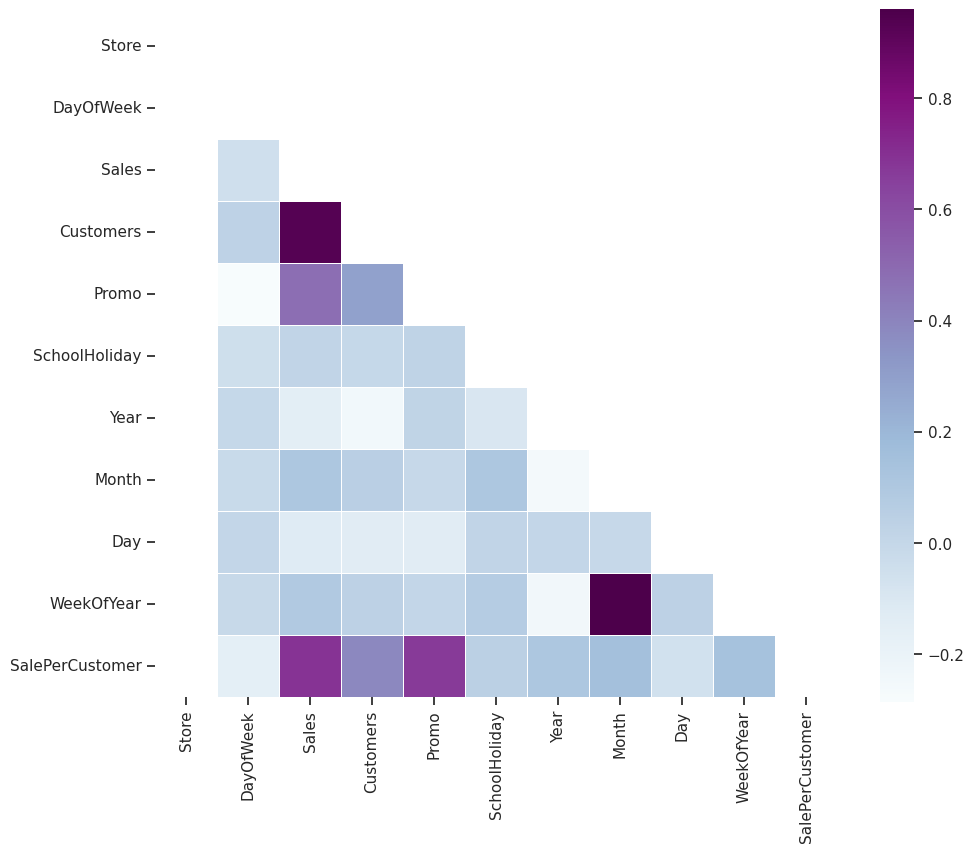

In [15]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train.drop(['Open', 'StateHoliday'], axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

## Decomposition

<Axes: xlabel='Date'>

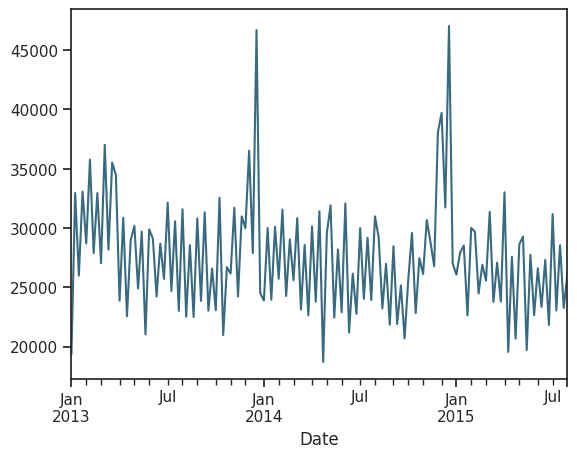

In [16]:
# preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

train['Sales'].resample('W').sum().plot(color = c)

<Axes: xlabel='Date'>

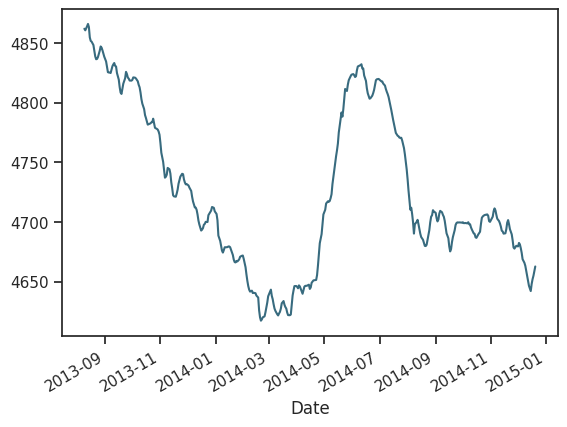

In [17]:
decomposition = seasonal_decompose(train['Sales'], model = 'additive', period=365)
decomposition.trend.plot(color = c)

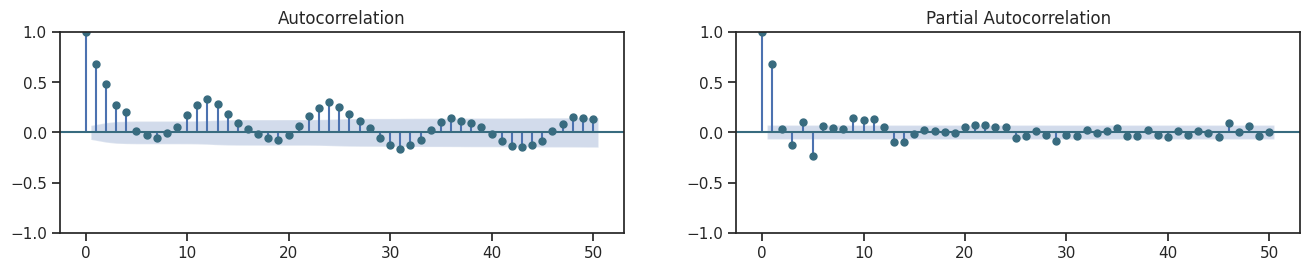

In [18]:
# figure for subplots
plt.figure(figsize = (16, 12))

plt.subplot(427); plot_acf(train['Sales'], lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(train['Sales'], lags = 50, ax = plt.gca(), color = c)

plt.show()

In [19]:
df = train.reset_index()

# sales for the store number 1 (StoreType C)
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes


X = df[df.Store == 1].sort_values('Date').reset_index(drop=True)

In [20]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})

sales = sales.sort_values('ds').reset_index(drop=True)
sales.head()

,ds,y
0,2013-01-02,5530.0
1,2013-01-03,4327.0
2,2013-01-04,4486.0
3,2013-01-05,4997.0
4,2013-01-07,7176.0


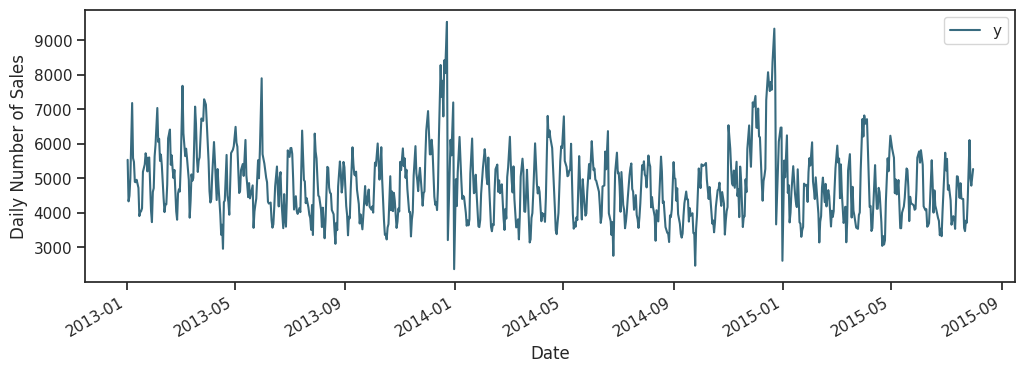

In [21]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

## Holidays combination

In [22]:
# create holidays dataframe
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))
holidays.head()

,holiday,ds
0,school_holiday,2015-07-31
1,school_holiday,2015-07-30
2,school_holiday,2015-07-29
3,school_holiday,2015-07-28
4,school_holiday,2015-07-27


# Base Prophet Prediction

In [59]:
### sales.shape

(781, 2)

In [23]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.fit(sales.iloc[:750])

# dataframe that extends into future 31 days 
future_dates = my_model.make_future_dataframe(periods = len(sales.iloc[750:]))

# print("First week to forecast.")
future_dates.tail(7)

11:51:18 - cmdstanpy - INFO - Chain [1] start processing
11:51:18 - cmdstanpy - INFO - Chain [1] done processing


,ds
774,2015-07-20
775,2015-07-21
776,2015-07-22
777,2015-07-23
778,2015-07-24
779,2015-07-25
780,2015-07-26


In [24]:
# predictions
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

In [25]:
resid_y = pd.concat([sales,fc['yhat']], axis=1).loc[lambda df: ~df['ds'].isnull()]
resid_y['res_y'] = resid_y['y'] - resid_y['yhat']
resid_y[:5]

,ds,y,yhat,res_y
0,2013-01-02,5530.0,5603.164872,-73.164872
1,2013-01-03,4327.0,5378.365136,-1051.365136
2,2013-01-04,4486.0,5535.068684,-1049.068684
3,2013-01-05,4997.0,5650.951184,-653.951184
4,2013-01-07,7176.0,5664.136975,1511.863025


In [26]:
resid_y.shape

(781, 4)

In [27]:
mean_squared_error(resid_y.iloc[:750]['y'], resid_y.iloc[:750]['yhat'], squared=False)

847.7149916424022

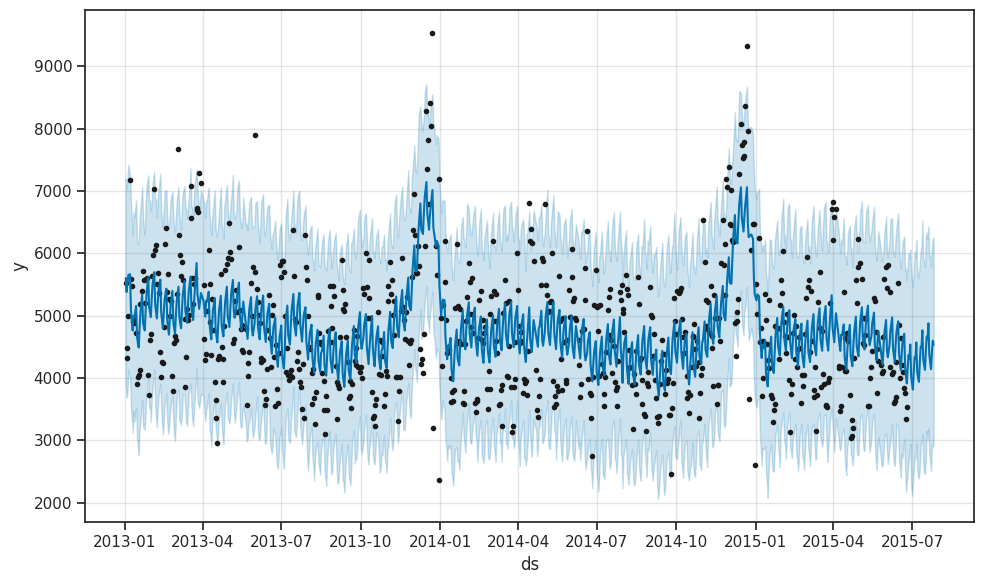

In [28]:
# visualizing predicions
my_model.plot(forecast);

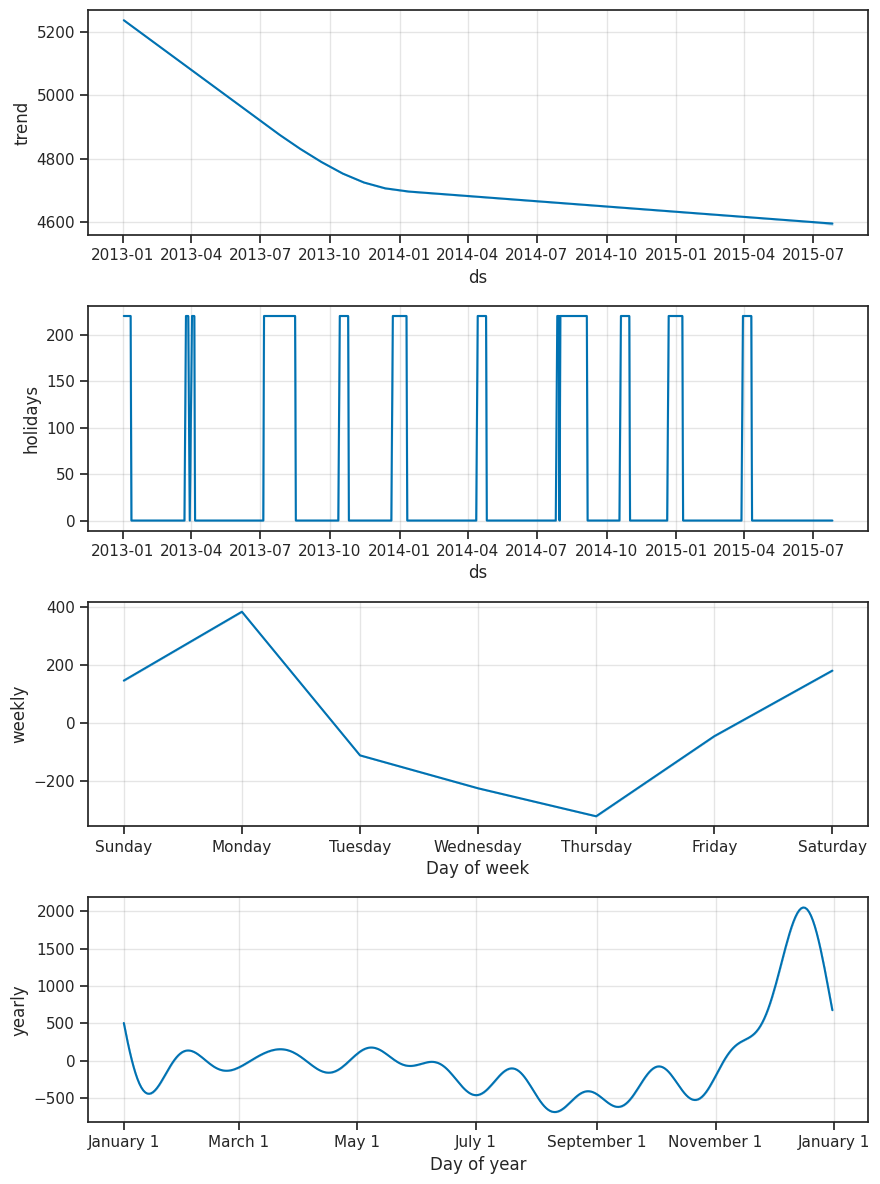

In [30]:
my_model.plot_components(forecast);

# Residual Analytics

In [31]:
X = df[df.Store == 1][['DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']]
X = X.sort_values("Date").reset_index(drop=True)


encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded = encoder.fit_transform(X[['StateHoliday']])
# Convert encoded array to DataFrame with appropriate column names
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['StateHoliday']))

# Concatenate the original data (excluding the original column) with encoded
X = pd.concat([X.drop('StateHoliday', axis=1), encoded_df], axis=1)


# X['StateHoliday'] = X['StateHoliday'].astype(int)
X['Date'] = pd.to_datetime(X['Date'])

print(X.shape)
# print(lgb_y['res_y'].shape)

(781, 8)


(array([ 2.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  2.,  2.,  5.,
         5., 10., 14., 23., 25., 29., 32., 41., 47., 39., 42., 38., 41.,
        35., 48., 43., 44., 33., 25., 36., 29., 21., 13., 14., 12.,  5.,
         5.,  4.,  4.,  2.,  3.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([-3209.39519343, -3084.6552396 , -2959.91528577, -2835.17533194,
        -2710.43537811, -2585.69542428, -2460.95547045, -2336.21551662,
        -2211.47556279, -2086.73560896, -1961.99565513, -1837.2557013 ,
        -1712.51574747, -1587.77579363, -1463.0358398 , -1338.29588597,
        -1213.55593214, -1088.81597831,  -964.07602448,  -839.33607065,
         -714.59611682,  -589.85616299,  -465.11620916,  -340.37625533,
         -215.6363015 ,   -90.89634767,    33.84360616,   158.58356   ,
          283.32351383,   408.06346766,   532.80342149,   657.54337532,
          782.28332915,   907.02328298,  1031.76323681,  1156.50319064,
         1281.24314447,  1405.9830983 ,  1530.72305213,  1655.463005

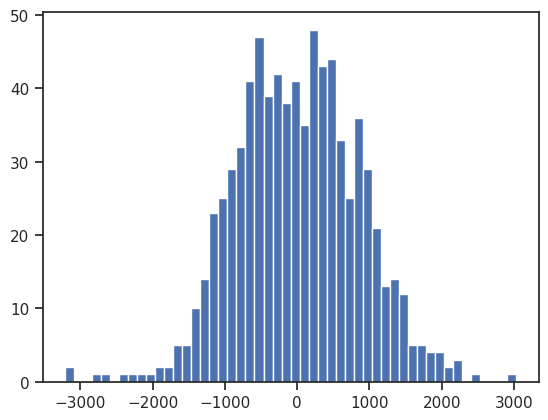

In [32]:
plt.hist(resid_y['res_y'], bins=50)

## Feature engineering

In [33]:
for lag in [1, 2, 3, 7, 14, 28]:
    X[f'lag_{lag}'] = X['Sales'].shift(lag)

In [34]:
for win in [3, 7, 14]:
    X[f'roll_mean_{win}'] = X['Sales'].shift(1).rolling(win).mean()
    X[f'roll_std_{win}']  = X['Sales'].shift(1).rolling(win).std()

In [35]:
X['dayofweek'] = X['Date'].dt.dayofweek
X['weekofyear'] = X['Date'].dt.isocalendar().week.astype(int)
X['month'] = X['Date'].dt.month
X['quarter'] = X['Date'].dt.quarter
X['year'] = X['Date'].dt.year
X['dayofmonth'] = X['Date'].dt.day

In [36]:
X['trend'] = forecast['trend']
X['additive_terms'] = forecast['additive_terms']
X['holidays'] = forecast['holidays']
X['school_holiday'] = forecast['school_holiday']
# X['seasonal'] = forecast['seasonal']
X['multiplicative_terms'] = forecast['multiplicative_terms']
X['seasonal_weekly'] = forecast['weekly']

X['seasonal_yearly'] = forecast['yearly']

In [38]:
X_train = X.iloc[:750, :].drop('Date', axis=1)
y_train = resid_y.iloc[:750, :]['res_y']

X_test = X.iloc[750:, :].drop('Date', axis=1)
y_test = resid_y.iloc[750:, :]['res_y']

## Penalized regression comparison

In [42]:
import joblib


X_reg = X.drop(["Date"], axis=1)

X_reg = X_reg.fillna(0)

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_reg)


# Define time series split
tscv = TimeSeriesSplit(n_splits=20)

best_overall_model = None
lowest_rmse = float('inf')
best_model_name = None

# Define models and parameter grids
models = {
    'Ridge': (Ridge(max_iter=500), {'model__alpha': [0.01, 0.1, 1, 10, 100]}),
    'Lasso': (Lasso(max_iter=500), {'model__alpha': [0.01, 0.1, 1, 10, 100]}),
    'ElasticNet': (ElasticNet(max_iter=500), {'model__alpha': [0.01, 0.1, 1, 10], 'model__l1_ratio': [0.2, 0.5, 0.8]})
}

results = {}

for name, (estimator, params) in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', estimator)
    ])
    grid = GridSearchCV(pipeline, param_grid=params, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid.fit(X_reg, resid_y['res_y'])

    best_rmse = -grid.best_score_
    best_params = grid.best_params_
    results[name] = {'RMSE': best_rmse, 'Best Params': best_params}

    # Track the best model
    if best_rmse < lowest_rmse:
        lowest_rmse = best_rmse
        best_overall_model = grid.best_estimator_
        best_model_name = name


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.978e+04, tolerance: 1.727e+04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.541e+04, tolerance: 2.333e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.089e+05, tolerance: 5.550e

In [66]:
results

{'Ridge': {'RMSE': 2.0871659062888734, 'Best Params': {'model__alpha': 0.01}},
 'Lasso': {'RMSE': 6.739606023875548, 'Best Params': {'model__alpha': 1}},
 'ElasticNet': {'RMSE': 22.19127670020817,
  'Best Params': {'model__alpha': 0.01, 'model__l1_ratio': 0.8}}}

In [43]:
reg_pred_y = best_overall_model.predict(X_test)

In [44]:
mean_squared_error(resid_y.iloc[750:]['y'], reg_pred_y, squared=False)

3957456.0684846938

## LightGBM implementation

In [45]:
lgb_X = X.iloc[:750, :].drop('Date', axis=1)
lgb_y = resid_y.iloc[:750, :]['res_y']

lgb_test_X = X.iloc[750:, :].drop('Date', axis=1)
lgb_test_y = resid_y.iloc[750:, :]['res_y']


X_train, X_val, y_train, y_val = train_test_split(lgb_X, lgb_y, test_size=0.1, shuffle=False)

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

model = lgb.train(
    params={
            'objective': 'regression', 
            'metric': 'rmse', 
            'learning_rate': 0.1, 
            'min_gain_to_split': 0, 
            'min_child_samples': 1, 
            'min_data_in_leaf': 1,
            },
    train_set=train_data,
    valid_sets=[train_data, val_data],
    # early_stopping_rounds=20,
    # verbose=True
)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=1 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=1 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4168
[LightGBM] [Info] Number of data points in the train set: 675, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=1 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Start training from score 3.014594


<Axes: >

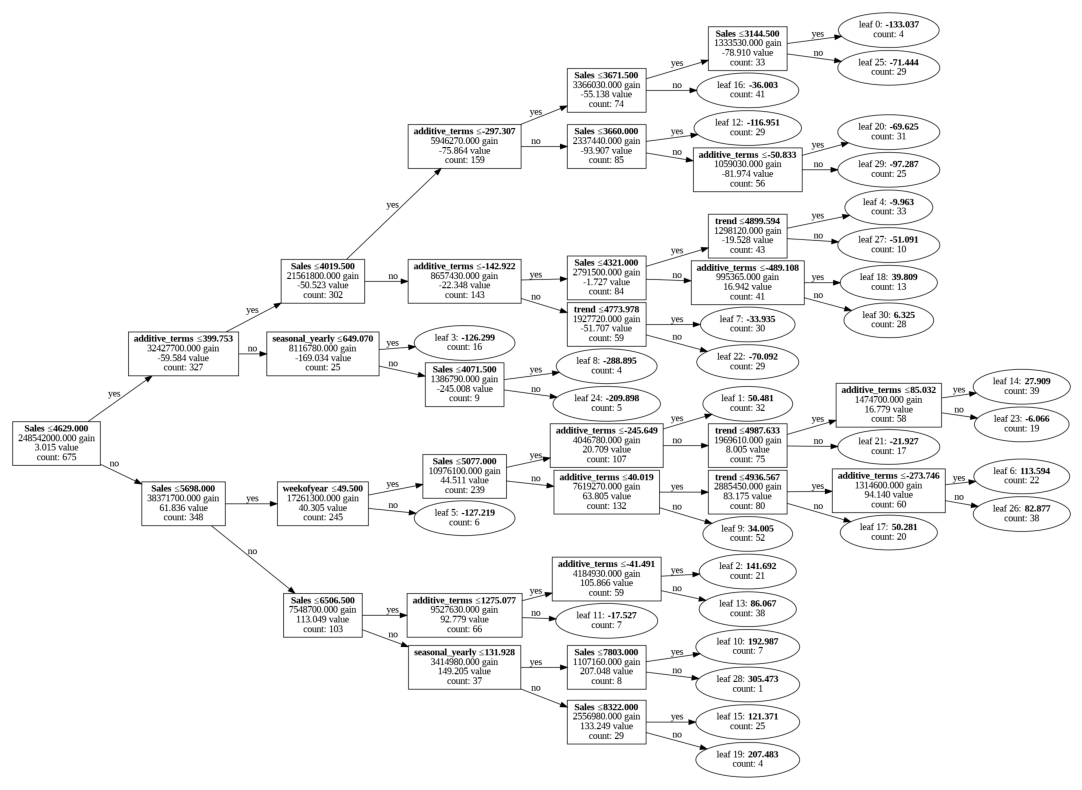

In [46]:
lgb.plot_tree(model, tree_index=0, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])


In [47]:
lgb_y_pred = model.predict(lgb_test_X)

In [65]:
mean_squared_error(lgb_y_pred, lgb_test_y.values, squared=False)

130.62785939662146

In [51]:
# Predict residuals
resid_y.loc[750:, 'pred_resid_y'] = lgb_y_pred

# Final forecast = Prophet + LightGBM residual prediction
resid_y['final_forecast'] = resid_y['yhat'] + resid_y['pred_resid_y']

In [62]:
resid_y[750:]

,ds,y,yhat,res_y,pred_resid_y,final_forecast
750,2015-06-26,3317.0,4161.504455,-844.504455,-1004.478241,3157.026215
751,2015-06-27,4019.0,4365.909965,-346.909965,-505.756645,3860.153320
752,2015-06-29,5197.0,4312.603444,884.396556,907.102622,5219.706066
753,2015-06-30,5735.0,4536.292683,1198.707317,1168.564401,5704.857084
754,2015-07-01,5223.0,4029.548065,1193.451935,1078.553152,5108.101217
755,2015-07-02,5558.0,3910.558661,1647.441339,1374.153191,5284.711852
756,2015-07-03,4665.0,3813.716940,851.283060,739.615142,4553.332082
757,2015-07-04,4797.0,4095.576029,701.423971,530.305873,4625.881902
758,2015-07-06,4359.0,4332.352518,26.647482,-43.851625,4288.500893
759,2015-07-07,3650.0,4312.236738,-662.236738,-833.329430,3478.907308


In [64]:
mean_squared_error(resid_y[750:]['y'], resid_y[750:]['final_forecast'], squared=False)

130.62785939662146

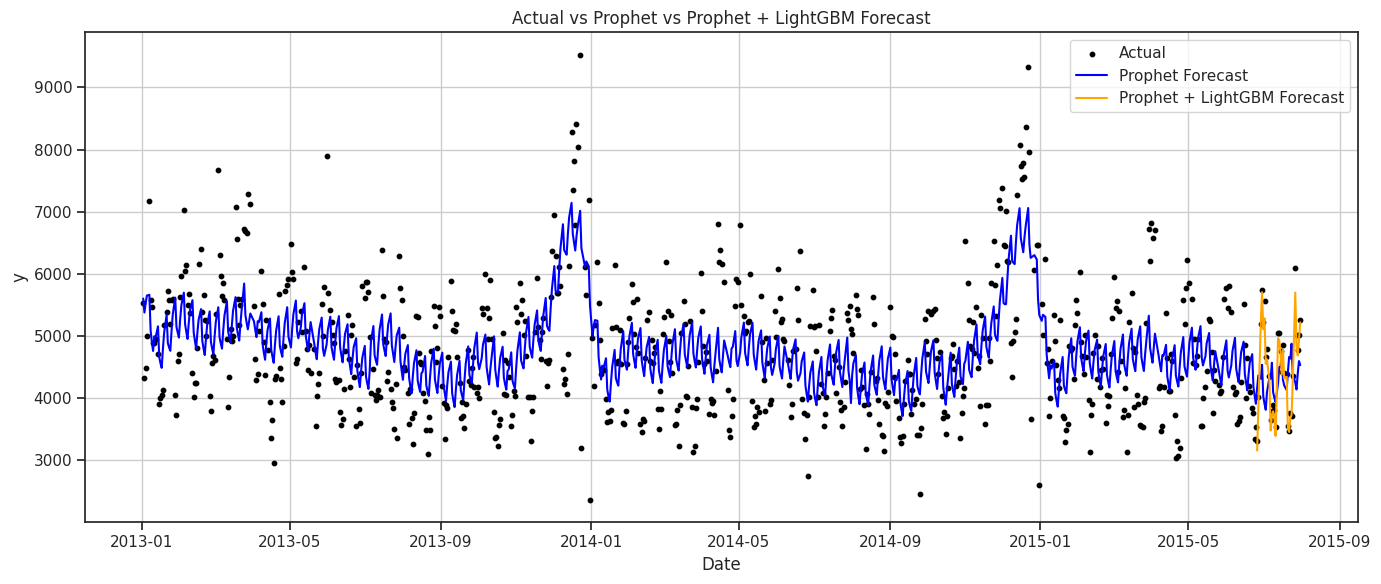

In [53]:
import matplotlib.pyplot as plt

# Assuming your DataFrame has the following columns:
# - 'ds': datetime
# - 'y': actual values
# - 'prophet_yhat': Prophet predictions
# - 'final_forecast': Prophet + LGBM residuals (combined model)

plt.figure(figsize=(14, 6))

# Actual data (dots)
plt.scatter(resid_y['ds'], resid_y['y'], color='black', s=10, label='Actual')

# Prophet prediction (blue line)
plt.plot(resid_y['ds'], resid_y['yhat'], color='blue', label='Prophet Forecast')

# Prophet + LGBM prediction (orange line)
plt.plot(resid_y['ds'], resid_y['final_forecast'], color='orange', label='Prophet + LightGBM Forecast')

plt.title("Actual vs Prophet vs Prophet + LightGBM Forecast")
plt.xlabel("Date")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
